# Experiment 1

In [1]:
from itertools import product
import json
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgb
from matplotlib.patches import Rectangle, Arrow, Circle
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42

import numpy as np
import seaborn as sns
import pandas as pd
from scipy import stats

from vgc_project.r import create_R_model_interface, ImmutableDataFrame
from vgc_project.parameter_fit import create_fit_vgc_model_to_trials, Trial

joblib_cache_location = "./_analysiscache"
rmods = create_R_model_interface(joblib_cache_location=joblib_cache_location)
fit_vgc_model_to_trials = create_fit_vgc_model_to_trials(joblib_cache_location=joblib_cache_location)

import analysisutils
from analysisutils import predictor_names, short_predictor_names
from prep_data import \
    mazes,\
    model_preds,\
    get_exp1_at

exp1_at = get_exp1_at()

R[write to console]: Loading required package: Matrix



Loading Experiment 1 Attention Trials


# Static VGC

## $\chi^2$ test

In [2]:
exp1_means = exp1_at.groupby(['grid', 'obstacle'])[["attention_N", "static_vgc_weight"]].mean().reset_index()
exp1_contab = pd.crosstab(exp1_means["attention_N"] >= .5, exp1_means["static_vgc_weight"] >= .5)
chi2, pval, dof, exp = stats.chi2_contingency(exp1_contab, correction=False)
chi2_effectsize_w = np.sqrt(chi2/len(exp1_means))
pval = analysisutils.pval_to_string(pval)
exp1_chi2_res = f"$\chi^2({dof}, N={len(exp1_means)})={chi2:.2f}$, $p {pval}$, effect size $w = {chi2_effectsize_w:.2f}$"

with open("./inputs/exp1_chi2_res_svgc.tex", "w") as f:
    f.write(exp1_chi2_res)
print(exp1_chi2_res)

$\chi^2(1, N=84)=23.03$, $p = 1.6 \times 10^{-6}$, effect size $w = 0.52$


## HGLM with VGC

In [3]:
exp1_at_im = ImmutableDataFrame(exp1_at)

In [4]:
exp1_vgc_single_summary = analysisutils.single_predictor_analysis(
    name='Exp. 1 VGC attention model',
    data=exp1_at_im,
    dv='attention_N',
    model_func='lmer',
    random_effects='(1 | sessionId) + (1 | grid)',
    predictor='static_vgc_weight_Z',
    rmods=rmods,
    coeff_digits=3,
    normalized_predictor=True
)
with open("./inputs/exp1_vgc_single_summary_svgc.tex", 'w') as file:
    file.write(exp1_vgc_single_summary.summary)
print(exp1_vgc_single_summary.summary)

$\chi^2(1) = 2297.21, p  < 1.0 \times 10^{-16}$; $\beta = 0.133$, S.E. $= 0.003$


## Exp 1 Figures

In [5]:
expmod_means = exp1_at.groupby(['grid', 'obstacle'])[['attention_N', "static_vgc_weight"]].\
    mean().reset_index()

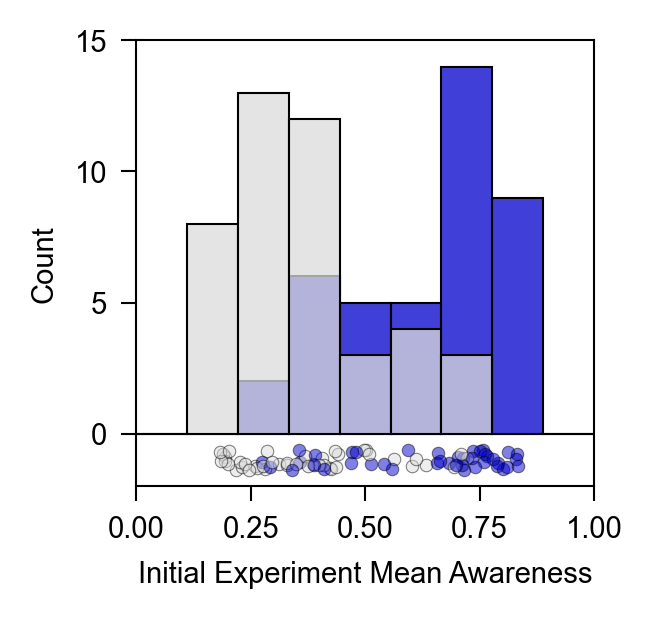

In [6]:
# create figure
fig_width_mm = 50
fig_height_mm = 50
mm_to_inch = 1/25.4 

assert fig_width_mm <= 182
assert fig_height_mm <= 245

import matplotlib.gridspec as gridspec
fig, ax = plt.subplots(
    1, 1, 
    figsize=(fig_width_mm*mm_to_inch, fig_height_mm*mm_to_inch),
    dpi=300
)
for spine in ['top','bottom','left','right']:
    ax.spines[spine].set_linewidth(.5)
    
    
bins = np.linspace(0, 1, 10)
sns.histplot(
    expmod_means[expmod_means['static_vgc_weight'] >= .5]['attention_N'],
    ax=ax, kde=False, bins=bins, color='mediumblue', linewidth=.5
)
sns.histplot(
    expmod_means[expmod_means['static_vgc_weight'] < .5]['attention_N'],
    ax=ax, kde=False, bins=bins, color='gainsboro', linewidth=.5
)

for _, row in expmod_means.iterrows():
    ax.plot(
        # [row['attention_N'], row['attention_N']], [-2, -.1],
        [row['attention_N'], ], [-1+(.5 - np.random.random())*.8],
        marker='.',
        alpha=.5,
        markersize=6,
        # markercolor='mediumblue' if row['vgc_weight'] >= .5 else 'gainsboro'
        color='mediumblue' if row['static_vgc_weight'] >= .5 else 'gainsboro',
        markeredgewidth=.25,
        markeredgecolor='k'
    )


ax.tick_params(axis='both', width=.5)
ax.set(**dict(
    xticks=[0, .25, .5, .75, 1],
    xlim=(0, 1),
    ylim=(-2, 15),
    yticks=[0, 5, 10, 15],
))
ax.set_xlabel('Initial Experiment Mean Awareness', fontsize=7, fontfamily = "Arial")
ax.set_ylabel('Count', fontsize=7, fontfamily = "Arial")
plt.yticks(fontname = "Arial", fontsize=7)
plt.xticks(fontname = "Arial", fontsize=7)
fig.savefig("results/exp1_hist_svgc.pdf")
# fig.set_dpi(150)

In [7]:
mediumblue = np.array(to_rgb('mediumblue'))
gainsboro = np.array(to_rgb('gainsboro'))

def color_mix(v, alpha=12):
    w = 1/(1 + np.exp(-alpha*(v-.5)))
    return (1-w)*gainsboro + w*mediumblue
    
def plot_grid_obstacle_values(
    tile_array,
    ax,
    feature_colors,
    obstacle_values,
    value_range,
    ax_pad=.25/4,
    color_mix_alpha=12,
    grid_lineweight=.25,
    invert_color=False
):
    grid_h, grid_w = len(tile_array), len(tile_array[0])
    for side in ['top','right','bottom','left']:
        ax.spines[side].set_visible(False)
    ax.tick_params(axis='both',which='both',labelbottom=False,bottom=False, left=False, labelleft=False)
    ax.set_xlim(-ax_pad, grid_w+ax_pad)
    ax.set_ylim(-ax_pad, grid_h+ax_pad)
    ax.set_aspect('equal')
    square = Rectangle(
        (0, 0),
        grid_w, grid_h,
        color='w',
        ec='k', 
        lw=grid_lineweight
    )
    ax.add_patch(square)
    
    grid_h, grid_w = len(tile_array), len(tile_array[0])
    obstacle_locs = {o: [] for o in obstacle_values}
    for x, y in product(range(grid_w), range(grid_h)):
        loc_feature = tile_array[grid_h - y - 1][x]
        if loc_feature in "0123456789":
            obs_value = obstacle_values[loc_feature]
            norm_value = (obs_value - value_range[0])/(value_range[1] - value_range[0])
            if invert_color:
                norm_value = 1 - norm_value
            loc_color = color_mix(norm_value, alpha=color_mix_alpha)
            obstacle_locs[loc_feature].append((x, y))
        elif loc_feature in feature_colors:
            loc_color = feature_colors[loc_feature]
        else:
            loc_color = 'white'
        square = Rectangle(
            (x, y),
            1, 1,
            color=loc_color,
            ec='grey', 
            lw=grid_lineweight
        )
        ax.add_patch(square)
        
        if loc_feature == "S":
            ax.plot(
                x + .5, y + .5,
                markeredgecolor='blue',
                marker='o',
                markersize=2.5,
                markeredgewidth=.5,
                fillstyle='none'
            )
        elif loc_feature == "G":
            goal = Rectangle(
                (x + .25, y + .25),
                .5, .5,
                color='green',
                lw=0
            )
            ax.add_patch(goal)

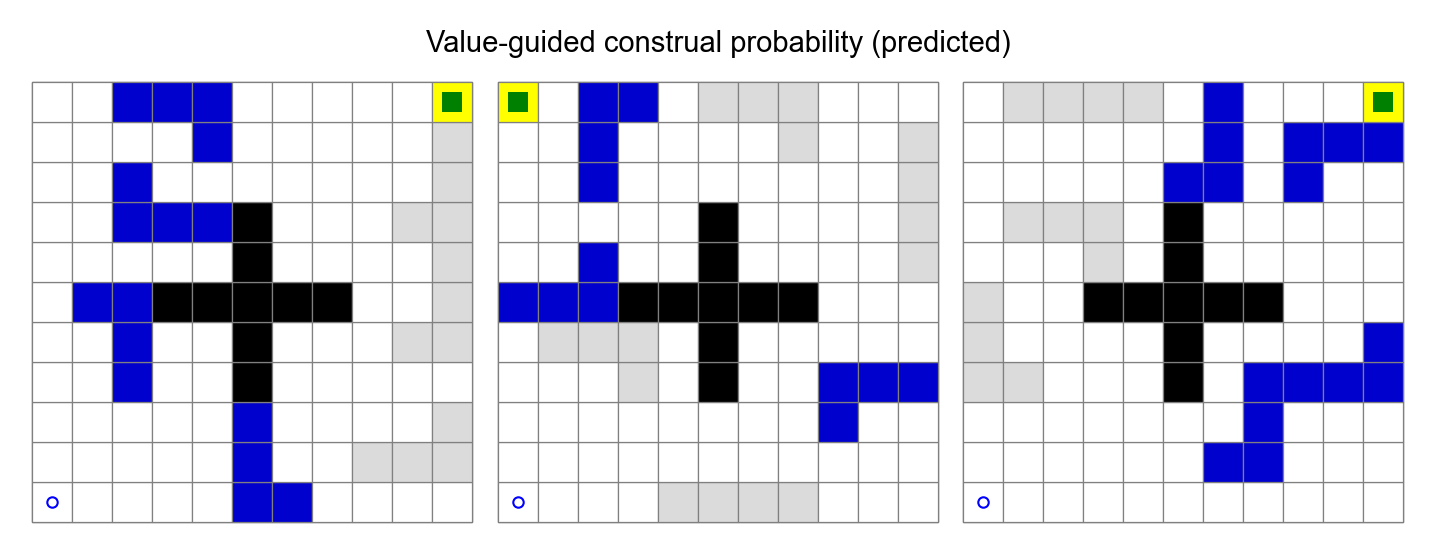

In [8]:
# model predictions
# create figure
fig_width_mm = 120
fig_height_mm = 60
mm_to_inch = 1/25.4 

assert fig_width_mm <= 182
assert fig_height_mm <= 245

import matplotlib.gridspec as gridspec
    
grids_to_plot = [11, 2, 5]
to_plot = expmod_means[expmod_means["grid"].apply(lambda gn: int(gn.split('-')[1]) in grids_to_plot)]
n_grids = len(to_plot['grid'].unique())
ncols = 3
nrows = n_grids // ncols

fig, axes = plt.subplots(
    nrows, ncols,
    figsize=(fig_width_mm*mm_to_inch, fig_height_mm*mm_to_inch),
    dpi=300
)
axes = list(axes.flatten())
measure = 'static_vgc_weight'

for gridname, rows in to_plot.groupby('grid'):
    grid_means = expmod_means.merge(pd.DataFrame({'grid': [gridname]}))
    obstacle_values = dict(zip(grid_means['obstacle'].apply(lambda o: o.split('-')[-1]), grid_means[measure]))
    ax = axes.pop(0)
    plot_grid_obstacle_values(
        tile_array=mazes[gridname],
        ax=ax,
        feature_colors={"#": "k", "G": "yellow"},
        obstacle_values=obstacle_values,
        value_range=(0, 1),
        grid_lineweight=.30
    )
suptitle = plt.suptitle("Value-guided construal probability (predicted)", font="Arial", y=.85)
suptitle.set_fontsize(7)
plt.tight_layout(pad=.5)
fig.savefig("results/exp1_3maze_preds_svgc.pdf")

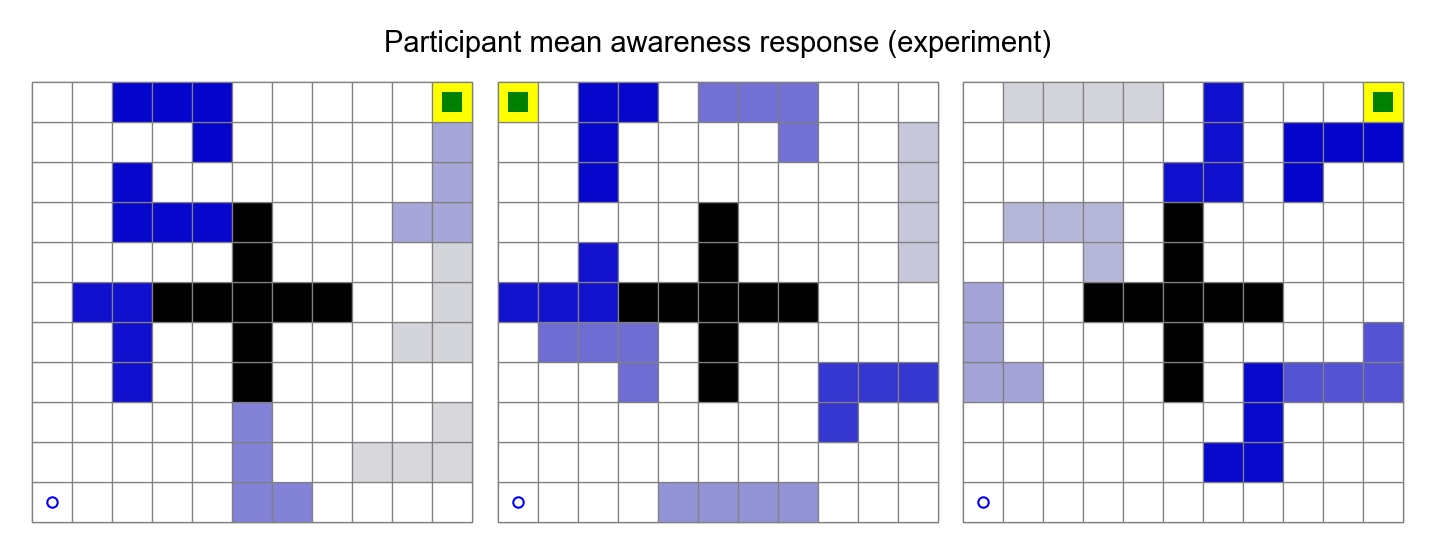

In [9]:
# responses
# create figure
fig_width_mm = 120
fig_height_mm = 60
mm_to_inch = 1/25.4 

assert fig_width_mm <= 182
assert fig_height_mm <= 245

import matplotlib.gridspec as gridspec
    
grids_to_plot = [11, 2, 5]
to_plot = expmod_means[expmod_means["grid"].apply(lambda gn: int(gn.split('-')[1]) in grids_to_plot)]
n_grids = len(to_plot['grid'].unique())
ncols = 3
nrows = n_grids // ncols

fig, axes = plt.subplots(
    nrows, ncols,
    figsize=(fig_width_mm*mm_to_inch, fig_height_mm*mm_to_inch),
    dpi=300
)
axes = list(axes.flatten())
measure = 'attention_N'

for gridname, rows in to_plot.groupby('grid'):
    grid_means = expmod_means.merge(pd.DataFrame({'grid': [gridname]}))
    obstacle_values = dict(zip(grid_means['obstacle'].apply(lambda o: o.split('-')[-1]), grid_means[measure]))
    ax = axes.pop(0)
    plot_grid_obstacle_values(
        tile_array=mazes[gridname],
        ax=ax,
        feature_colors={"#": "k", "G": "yellow"},
        obstacle_values=obstacle_values,
        value_range=(0, 1),
        grid_lineweight=.30
    )
suptitle = plt.suptitle("Participant mean awareness response (experiment)", font="Arial", y=.85)
suptitle.set_fontsize(7)
plt.tight_layout(pad=.5)
fig.savefig("results/exp1_3maze_data_svgc.pdf")

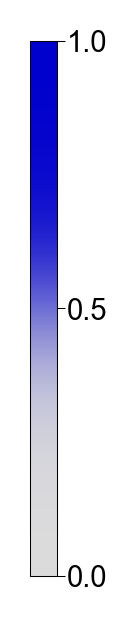

In [10]:
from matplotlib.colors import ListedColormap, Normalize
from matplotlib import cm

N=256
vmin=0
vmax=1
ticks=[0, .5, 1]

fig_width_mm = 20
fig_height_mm = 60
mm_to_inch = 1/25.4 

assert fig_width_mm <= 182
assert fig_height_mm <= 245

fig, ax = plt.subplots(
    1, 1,
    figsize=(fig_width_mm*mm_to_inch, fig_height_mm*mm_to_inch),
    dpi=300
)

vals = np.linspace(0, 1, N)[:,None]
vals = color_mix(vals)
newcmp = ListedColormap(vals)
norm = Normalize(vmin=vmin, vmax=vmax)
cb = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=newcmp), ticks=ticks)
cb.ax.tick_params(axis = 'both', which = 'major', width=.25, length=2, pad=.5)
cb.outline.set_linewidth(.25)
cb.minorticks_off()
for l in cb.ax.yaxis.get_ticklabels():
    l.set_family("Arial")
    l.set_fontsize(7)
ax.remove()
fig.savefig("results/exp1_colorbar_svgc.pdf")